# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
warnings.filterwarnings("ignore")
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

# 2. Data Loading

## a. Data Importing

In [2]:
# As mentioned in the assignment details, "Select" is as good as a Null or NaN value, hence treating it as a Null Value
df_leads_v1 = pd.read_csv("Leads.csv", na_values = ["Select"])

## b. Data Check and Stats

In [3]:
for col in df_leads_v1.columns:
    print(f"Column: {col}")
    print(df_leads_v1[col].head(2))
    print("---" * 20)

Column: Prospect ID
0    7927b2df-8bba-4d29-b9a2-b6e0beafe620
1    2a272436-5132-4136-86fa-dcc88c88f482
Name: Prospect ID, dtype: object
------------------------------------------------------------
Column: Lead Number
0    660737
1    660728
Name: Lead Number, dtype: int64
------------------------------------------------------------
Column: Lead Origin
0    API
1    API
Name: Lead Origin, dtype: object
------------------------------------------------------------
Column: Lead Source
0        Olark Chat
1    Organic Search
Name: Lead Source, dtype: object
------------------------------------------------------------
Column: Do Not Email
0    No
1    No
Name: Do Not Email, dtype: object
------------------------------------------------------------
Column: Do Not Call
0    No
1    No
Name: Do Not Call, dtype: object
------------------------------------------------------------
Column: Converted
0    0
1    0
Name: Converted, dtype: int64
-------------------------------------------------------

In [4]:
# Get the shape of the dataset
df_leads_v1.shape

(9240, 37)

In [5]:
# Check the data type and non-null count of all the columns
df_leads_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

#### Interpretation:
There are missing values in the dataset

In [6]:
# Check data distribution for numeric columns
df_leads_v1.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,"9,240.00","9,240.00","9,103.00","9,240.00","9,103.00","5,022.00","5,022.00"
mean,"617,188.44",0.39,3.45,487.70,2.36,14.31,16.34
std,"23,406.00",0.49,4.85,548.02,2.16,1.39,1.81
min,"579,533.00",0.00,0.00,0.00,0.00,7.00,11.00
25%,"596,484.50",0.00,1.00,12.00,1.00,14.00,15.00
50%,"615,479.00",0.00,3.00,248.00,2.00,14.00,16.00
75%,"637,387.25",1.00,5.00,936.00,3.00,15.00,18.00
max,"660,737.00",1.00,251.00,"2,272.00",55.00,18.00,20.00


#### Interpretation:
- Only 40% on average were converted
- Total Visits contain outliers. Suspicious that a customer visited the page 251 times.
- Total Time Spent On Website contain outliers
- Page Views Per Visit contain outliers

In [7]:
# Check null values count for each column
df_leads_v1.isnull().sum()

Prospect ID                                         0
Lead Number                                         0
Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   3380
How did you hear about X Education               7250
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article           

In [8]:
# Check the number of duplicate rows
df_leads_v1.duplicated().sum()
# No duplicate rows present in the dataset

0

# 3. Data Preprocessing

## a. Rename columns to a shorter name

In [9]:
# Rename columns that are too long
df_leads_v2 = df_leads_v1.rename(columns={
    "How did you hear about X Education": "Customer_Source",
    "What is your current occupation": "Occupation",
    "What matters most to you in choosing a course": "Motto",
    "Through Recommendations": "Recommendations",
    "Receive More Updates About Our Courses": "Receive Course Updates",
    "Update me on Supply Chain Content": "Receive SCM Updates",
    "Get updates on DM Content": "Receive DM Content Updates",
    "I agree to pay the amount through cheque": "Cheque Payment",
    "A free copy of Mastering The Interview": "Free copy"
})

## b. Fix Missing Values

#### Criteria to remove missing values:
- Remove columns if %(data) missing in the respective column > __approx(30%)__
- Remove rows if %(data) missing the respective column < __5%__
- Impute the missing value if %(data) missing __>5% and approx(<30%)__

In [10]:
# Missing values in terms of percentage
(df_leads_v2.isnull().sum() / df_leads_v2.shape[0])*100

Prospect ID                    0.00
Lead Number                    0.00
Lead Origin                    0.00
Lead Source                    0.39
Do Not Email                   0.00
Do Not Call                    0.00
Converted                      0.00
TotalVisits                    1.48
Total Time Spent on Website    0.00
Page Views Per Visit           1.48
Last Activity                  1.11
Country                       26.63
Specialization                36.58
Customer_Source               78.46
Occupation                    29.11
Motto                         29.32
Search                         0.00
Magazine                       0.00
Newspaper Article              0.00
X Education Forums             0.00
Newspaper                      0.00
Digital Advertisement          0.00
Recommendations                0.00
Receive Course Updates         0.00
Tags                          36.29
Lead Quality                  51.59
Receive SCM Updates            0.00
Receive DM Content Updates  

#### Interpretation: Columns with missing data approx or more than 30%
- Customer_Source
- Lead Quality
- Lead Profile
- Asymmetrique Activity Index
- Asymmetrique Profile Index
- Asymmetrique Activity Score
- Asymmetrique Profile Score
- City
- Occupation
- Motto
- Specialization
- Tags

In [11]:
# Removing the above columns from the dataset
df_leads_v3 = df_leads_v2.drop([
    "Customer_Source",
    "Lead Quality",
    "Lead Profile",
    "Asymmetrique Activity Index",
    "Asymmetrique Profile Index",
    "Asymmetrique Activity Score",
    "Asymmetrique Profile Score",
    "City",
    "Occupation",
    "Motto",
    "Specialization",
    "Tags"
], axis=1)

In [12]:
# Rechecking the number of missing rows
df_leads_v3.isnull().sum()

Prospect ID                       0
Lead Number                       0
Lead Origin                       0
Lead Source                      36
Do Not Email                      0
Do Not Call                       0
Converted                         0
TotalVisits                     137
Total Time Spent on Website       0
Page Views Per Visit            137
Last Activity                   103
Country                        2461
Search                            0
Magazine                          0
Newspaper Article                 0
X Education Forums                0
Newspaper                         0
Digital Advertisement             0
Recommendations                   0
Receive Course Updates            0
Receive SCM Updates               0
Receive DM Content Updates        0
Cheque Payment                    0
Free copy                         0
Last Notable Activity             0
dtype: int64

In [13]:
# Finding the count of missing values in the country column
df_leads_v3[df_leads_v3["Country"].isna()].shape

(2461, 25)

#### Interpretation
- 2461 countries are labelled as NaN and assuming a value for the same will hamper our prediction
- Hence, we decided to remove the entire column

In [14]:
df_leads_v4 = df_leads_v3.drop(["Country"], axis=1)

In [15]:
(df_leads_v4.isnull().sum() / df_leads_v4.shape[0]) * 100

Prospect ID                   0.00
Lead Number                   0.00
Lead Origin                   0.00
Lead Source                   0.39
Do Not Email                  0.00
Do Not Call                   0.00
Converted                     0.00
TotalVisits                   1.48
Total Time Spent on Website   0.00
Page Views Per Visit          1.48
Last Activity                 1.11
Search                        0.00
Magazine                      0.00
Newspaper Article             0.00
X Education Forums            0.00
Newspaper                     0.00
Digital Advertisement         0.00
Recommendations               0.00
Receive Course Updates        0.00
Receive SCM Updates           0.00
Receive DM Content Updates    0.00
Cheque Payment                0.00
Free copy                     0.00
Last Notable Activity         0.00
dtype: float64

#### Interpretation
- Missing value percentage is less than 5% for the above columns hence removing the missing rows

In [16]:
df_leads_v4[df_leads_v4["TotalVisits"].isna() != df_leads_v4["Page Views Per Visit"].isna()]

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,X Education Forums,Newspaper,Digital Advertisement,Recommendations,Receive Course Updates,Receive SCM Updates,Receive DM Content Updates,Cheque Payment,Free copy,Last Notable Activity


#### Interpretation
- "TotalVisits" and "Page Views Per Visit" column have identical missing values
- Hence, we can drop the rows from any one column and it will have similar effect on the other

In [17]:
df_leads_v5 = df_leads_v4.dropna(subset=["TotalVisits"])

In [18]:
# Rechecking the percentage of missing values
(df_leads_v5.isnull().sum() / df_leads_v5.shape[0]) * 100

Prospect ID                   0.00
Lead Number                   0.00
Lead Origin                   0.00
Lead Source                   0.32
Do Not Email                  0.00
Do Not Call                   0.00
Converted                     0.00
TotalVisits                   0.00
Total Time Spent on Website   0.00
Page Views Per Visit          0.00
Last Activity                 0.00
Search                        0.00
Magazine                      0.00
Newspaper Article             0.00
X Education Forums            0.00
Newspaper                     0.00
Digital Advertisement         0.00
Recommendations               0.00
Receive Course Updates        0.00
Receive SCM Updates           0.00
Receive DM Content Updates    0.00
Cheque Payment                0.00
Free copy                     0.00
Last Notable Activity         0.00
dtype: float64

#### Interpretation
- Since the percentage of missing values for Lead Source column is not even 1% we can drop the rows for the same

In [19]:
df_leads_v6 = df_leads_v5.dropna(subset=["Lead Source"])

In [20]:
# Rechecking the number of missing values
df_leads_v6.isnull().sum()

Prospect ID                    0
Lead Number                    0
Lead Origin                    0
Lead Source                    0
Do Not Email                   0
Do Not Call                    0
Converted                      0
TotalVisits                    0
Total Time Spent on Website    0
Page Views Per Visit           0
Last Activity                  0
Search                         0
Magazine                       0
Newspaper Article              0
X Education Forums             0
Newspaper                      0
Digital Advertisement          0
Recommendations                0
Receive Course Updates         0
Receive SCM Updates            0
Receive DM Content Updates     0
Cheque Payment                 0
Free copy                      0
Last Notable Activity          0
dtype: int64

## c. Delete unnecessary columns

In [21]:
# Extract unique values from each column
for col in df_leads_v6.columns:
    print(f"Column {col}")
    print(df_leads_v6[col].value_counts())
    print("---" * 20)

Column Prospect ID
31f2daeb-915e-4fb6-bff8-10824628b3a5    1
774e7a4e-e871-4a67-aaa1-4609f2bf2cea    1
3ae07743-278b-42bf-a07c-65b53a57a493    1
f5805756-cbdb-408b-b879-5256de677692    1
9e585679-182a-406c-ab12-3b0d48257427    1
                                       ..
54a99eb2-8634-483f-8826-03296b90f3e8    1
a1dea2f8-4e06-4d2e-9ab1-019e11180916    1
937b0c41-c9d7-47c4-ac62-110bdc48e069    1
a7162628-da7b-4c9b-b9e8-4b2ea599dcc4    1
f0cb919e-d1ae-41c9-ade0-55eb110a1556    1
Name: Prospect ID, Length: 9074, dtype: int64
------------------------------------------------------------
Column Lead Number
608255    1
656682    1
634167    1
625971    1
646449    1
         ..
582137    1
643807    1
600800    1
598753    1
655360    1
Name: Lead Number, Length: 9074, dtype: int64
------------------------------------------------------------
Column Lead Origin
Landing Page Submission    4885
API                        3578
Lead Add Form               581
Lead Import                  30
Name: L

In [22]:
# Check if Lead Number column contains any unique entry
print("Total number of unique Lead Number: ", len(df_leads_v6["Lead Number"].unique()))

Total number of unique Lead Number:  9074


#### Interpretation 
- As there are not duplicate values in the lead number column and, the task is to assign a lead score to each lead, there is no purpose to keep "Prospect ID" column in the dataset. Hence, removing "Prospect ID" column.
- Also below columns can be removed from the dataset as they contain only one category/distinct value and removing them will not affect our prediction
    - Magazine
    - Receive Course Updates
    - Receive SCM Updates
    - Receive DM Content Updates
    - Cheque Payment

In [23]:
df_leads_v7 = df_leads_v6.drop([
    "Prospect ID",
    "Magazine",
    "Receive Course Updates",
    "Receive SCM Updates",
    "Receive DM Content Updates",
    "Cheque Payment"
], axis=1)

#### Interpretation: 
- Below columns can be removed from the dataset as they contain information of only ads seen by the customer. They don't contribute to knowing whether the customer will get converted to lead or not.
    - Search
    - Newspaper Article
    - X Education Forums
    - Newspaper
    - Digital Advertisement

In [24]:
df_leads_v8 = df_leads_v7.drop([
    "Search",
    "Newspaper Article",
    "X Education Forums",
    "Newspaper",
    "Digital Advertisement"
], axis=1)

## d. Data conversion
- Yes will be converted to 1
- No will be converted to 0

In [25]:
for col in df_leads_v8.columns:
    if col not in ["Lead Number", "TotalVisits", "Total Time Spent on Website", "Page Views Per Visit"]: # Ignoring the continuous columns
        print(f"Column: {col}")
        print(df_leads_v8[col].value_counts())
        print("---"*20)

Column: Lead Origin
Landing Page Submission    4885
API                        3578
Lead Add Form               581
Lead Import                  30
Name: Lead Origin, dtype: int64
------------------------------------------------------------
Column: Lead Source
Google               2868
Direct Traffic       2543
Olark Chat           1753
Organic Search       1154
Reference             443
Welingak Website      129
Referral Sites        125
Facebook               31
bing                    6
google                  5
Click2call              4
Live Chat               2
Press_Release           2
Social Media            2
blog                    1
WeLearn                 1
NC_EDM                  1
youtubechannel          1
Pay per Click Ads       1
welearnblog_Home        1
testone                 1
Name: Lead Source, dtype: int64
------------------------------------------------------------
Column: Do Not Email
No     8358
Yes     716
Name: Do Not Email, dtype: int64
----------------------

In [26]:
# Data conversion
binary_columns = ["Do Not Email", "Do Not Call", "Recommendations", "Free copy"]

for col in binary_columns:
    df_leads_v8[col] = df_leads_v8[col].map({"Yes": 1, "No": 0})

In [27]:
df_leads_v8["Lead Source"].value_counts()

Google               2868
Direct Traffic       2543
Olark Chat           1753
Organic Search       1154
Reference             443
Welingak Website      129
Referral Sites        125
Facebook               31
bing                    6
google                  5
Click2call              4
Live Chat               2
Press_Release           2
Social Media            2
blog                    1
WeLearn                 1
NC_EDM                  1
youtubechannel          1
Pay per Click Ads       1
welearnblog_Home        1
testone                 1
Name: Lead Source, dtype: int64

#### Interpretation
- Google, google represent the same thing
- Google, google, bing are all Web Search Engines
- Facebook, Social Media, youtubechannel are all social media platforms
- Hence we can group the above columns into Web Search, Social Media, and Others

In [28]:
df_leads_v8["Lead Source"] = df_leads_v8["Lead Source"].replace(["google", "bing", "Google"], "Search Engine")
df_leads_v8["Lead Source"] = df_leads_v8["Lead Source"].replace(["Facebook", "youtubechannel"], "Social Media")
df_leads_v8["Lead Source"] = df_leads_v8["Lead Source"].apply(lambda x: "Others" if x not in ["Search Engine", "Social Media"] else x)

In [29]:
df_leads_v8["Last Activity"].value_counts()

Email Opened                    3432
SMS Sent                        2716
Olark Chat Conversation          972
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    312
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       90
Unsubscribed                      59
Had a Phone Conversation          25
View in browser link Clicked       6
Approached upfront                 5
Email Received                     2
Email Marked Spam                  2
Resubscribed to emails             1
Visited Booth in Tradeshow         1
Name: Last Activity, dtype: int64

#### Interpretation
- We decided to group Form Submitted on Website, Unreachable, Unsubscribed, Had a Phone Conversation, View in browser link Clicked, Approached upfront, Email Received, Email Marked Spam, Resubscribed to emails, Visited Booth in Tradeshow into the "Others" category as their individual counts are less compared to others

In [30]:
df_leads_v8["Last Activity"] = df_leads_v8["Last Activity"].replace(["Form Submitted on Website", "Unreachable", "Unsubscribed", "Had a Phone Conversation", "View in browser link Clicked", "Approached upfront", "Email Received", "Email Marked Spam", "Resubscribed to emails", "Visited Booth in Tradeshow"], "Other Last Activities")

In [31]:
df_leads_v8["Last Activity"].value_counts()

Email Opened               3432
SMS Sent                   2716
Olark Chat Conversation     972
Page Visited on Website     640
Converted to Lead           428
Email Bounced               312
Other Last Activities       307
Email Link Clicked          267
Name: Last Activity, dtype: int64

In [32]:
df_leads_v8["Last Notable Activity"].value_counts()

Modified                        3267
Email Opened                    2823
SMS Sent                        2152
Page Visited on Website          318
Olark Chat Conversation          183
Email Link Clicked               173
Email Bounced                     60
Unsubscribed                      45
Unreachable                       32
Had a Phone Conversation          14
Email Marked Spam                  2
Approached upfront                 1
Form Submitted on Website          1
Email Received                     1
Resubscribed to emails             1
View in browser link Clicked       1
Name: Last Notable Activity, dtype: int64

#### Interpretation
- Referring to the previous operation we decided to categorise Unsubscribed, Unreachable, Had a Phone Conversation, Email Marked Spam, View in browser link Clicked, Resubscribed to emails, Email Received, Approached upfront, Form Submitted on Website into "Other Notable Activities" category

In [33]:
df_leads_v8["Last Notable Activity"] = df_leads_v8["Last Notable Activity"].replace(["Unsubscribed", "Unreachable", "Had a Phone Conversation", "Email Marked Spam", "View in browser link Clicked", "Resubscribed to emails", "Email Received", "Approached upfront", "Form Submitted on Website"], "Other Notable Activities")

## e. Sanity Check

In [34]:
# Sanity check
df_leads_v8.sample(3)

,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Recommendations,Free copy,Last Notable Activity
5182,610164,API,Search Engine,0,0,0,1.00,55,1.00,Converted to Lead,0,0,Modified
733,652828,API,Others,0,0,0,7.00,103,3.50,Page Visited on Website,0,0,Modified
1868,641424,Landing Page Submission,Search Engine,0,0,0,4.00,355,4.00,Email Opened,0,0,Email Opened


In [35]:
# Lead Numbers are unique
df_leads_v8[df_leads_v8["Lead Number"].duplicated()]

,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Recommendations,Free copy,Last Notable Activity


#### Interpretation:
No duplicate values present in "Lead Number" feature

In [36]:
# Total visits should not be zero if Page Views Per Visit > 0
df_leads_v8[(df_leads_v8["TotalVisits"] == 0) & (df_leads_v8["Page Views Per Visit"] > 0)] # Looks okay

,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Recommendations,Free copy,Last Notable Activity


In [37]:
# The following columns should not have negative values
# TotalVisits, Page Views Per Visit, Total Time Spent on Website
print(len(df_leads_v8[df_leads_v8["TotalVisits"] < 0])) # Looks okay
print(len(df_leads_v8[df_leads_v8["Page Views Per Visit"] < 0])) # Looks okay
print(len(df_leads_v8[df_leads_v8["Total Time Spent on Website"] < 0])) # Looks okay

0
0
0


## f. Fix incorrect data types and index

In [38]:
# TotalVisits column contains only integer values. Hence we can convert the data type to integer
df_leads_v8["TotalVisits"].value_counts()

0.00      2161
2.00      1679
3.00      1306
4.00      1120
5.00       783
6.00       466
1.00       395
7.00       309
8.00       224
9.00       164
10.00      114
11.00       86
13.00       48
12.00       45
14.00       36
16.00       21
15.00       18
17.00       16
18.00       15
20.00       12
19.00        9
23.00        6
21.00        6
27.00        5
24.00        5
25.00        5
22.00        3
28.00        2
29.00        2
26.00        2
251.00       1
74.00        1
30.00        1
141.00       1
54.00        1
41.00        1
115.00       1
43.00        1
42.00        1
32.00        1
55.00        1
Name: TotalVisits, dtype: int64

In [39]:
df_leads_v8["TotalVisits"] = df_leads_v8["TotalVisits"].astype(int)

In [40]:
# Since we have dropped columns checking the index position
df_leads_v8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9074 entries, 0 to 9239
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Lead Number                  9074 non-null   int64  
 1   Lead Origin                  9074 non-null   object 
 2   Lead Source                  9074 non-null   object 
 3   Do Not Email                 9074 non-null   int64  
 4   Do Not Call                  9074 non-null   int64  
 5   Converted                    9074 non-null   int64  
 6   TotalVisits                  9074 non-null   int32  
 7   Total Time Spent on Website  9074 non-null   int64  
 8   Page Views Per Visit         9074 non-null   float64
 9   Last Activity                9074 non-null   object 
 10  Recommendations              9074 non-null   int64  
 11  Free copy                    9074 non-null   int64  
 12  Last Notable Activity        9074 non-null   object 
dtypes: float64(1), int

In [41]:
# Resetting the index to correct entries
# from Int64Index: 9074 entries, 0 to 9239 to Int64Index: 9074 entries, 0 to 9073
df_leads_v9 = df_leads_v8.reset_index(drop=True)

In [42]:
df_leads_v9.info() # Looks okay

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9074 entries, 0 to 9073
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Lead Number                  9074 non-null   int64  
 1   Lead Origin                  9074 non-null   object 
 2   Lead Source                  9074 non-null   object 
 3   Do Not Email                 9074 non-null   int64  
 4   Do Not Call                  9074 non-null   int64  
 5   Converted                    9074 non-null   int64  
 6   TotalVisits                  9074 non-null   int32  
 7   Total Time Spent on Website  9074 non-null   int64  
 8   Page Views Per Visit         9074 non-null   float64
 9   Last Activity                9074 non-null   object 
 10  Recommendations              9074 non-null   int64  
 11  Free copy                    9074 non-null   int64  
 12  Last Notable Activity        9074 non-null   object 
dtypes: float64(1), int

# 4. Exploratory Data Analysis and Visualization

In [43]:
global_title_design = {
    "fontsize":15,
    "fontweight": 5,
    "color": "green"
}

global_axis_design = {
    "fontsize":12,
    "fontweight": 5,
    "color": "brown"
}

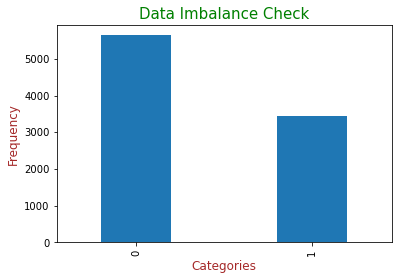

In [44]:
# Data Imbalance Check
df_leads_v9["Converted"].value_counts().plot(kind="bar", width=0.4)
plt.title("Data Imbalance Check", fontdict=global_title_design)
plt.xlabel("Categories", fontdict=global_axis_design)
plt.ylabel("Frequency", fontdict=global_axis_design)
plt.show()

#### Interpretation
- Lead conversion is lesser
- The data imbalance is not there. Values from both the categories are equally considered for the representation. Hence, model can be built on the provided dataset

## Univariate Analysis

### a. Categorical variables visualization

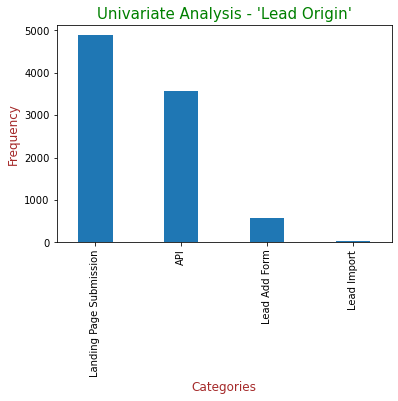

In [45]:
df_leads_v9["Lead Origin"].value_counts().plot(kind="bar", width=0.4)
plt.title("Univariate Analysis - 'Lead Origin'", fontdict=global_title_design)
plt.xlabel("Categories", fontdict=global_axis_design)
plt.ylabel("Frequency", fontdict=global_axis_design)
plt.show()

#### Intepretation:
- A higher percentage of people clicked on Advertisements leading to a higher contribution of "Landing Page Submission" followed by API
- Very less people were identified as lead through form and import procedure

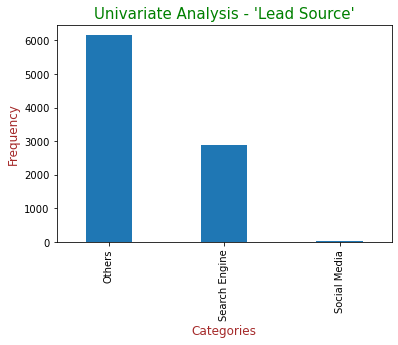

In [46]:
df_leads_v9["Lead Source"].value_counts().plot(kind="bar", width=0.4)
plt.title("Univariate Analysis - 'Lead Source'", fontdict=global_title_design)
plt.xlabel("Categories", fontdict=global_axis_design)
plt.ylabel("Frequency", fontdict=global_axis_design)
plt.show()

#### Interpretation:
- Very less percentage of people have been identified as lead through social media and web search engine
- This suggests that the firm's website isn't listed in the top rankings in a search history

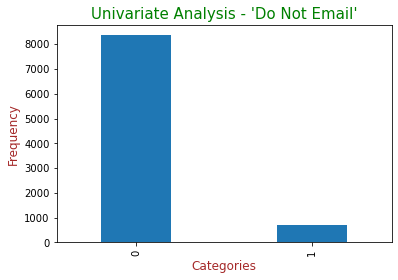

In [47]:
df_leads_v9["Do Not Email"].value_counts().plot(kind="bar", width=0.4)
plt.title("Univariate Analysis - 'Do Not Email'", fontdict=global_title_design)
plt.xlabel("Categories", fontdict=global_axis_design)
plt.ylabel("Frequency", fontdict=global_axis_design)
plt.show()

#### Interpretation
- A lot of people are interested in receiving emails and other information about the courses offered by the firm. This is a positive sign

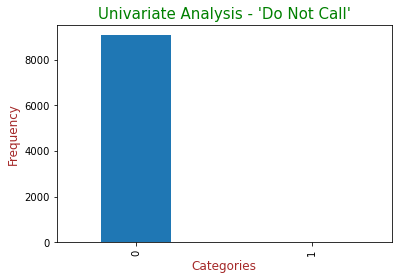

In [48]:
df_leads_v9["Do Not Call"].value_counts().plot(kind="bar", width=0.4)
plt.title("Univariate Analysis - 'Do Not Call'", fontdict=global_title_design)
plt.xlabel("Categories", fontdict=global_axis_design)
plt.ylabel("Frequency", fontdict=global_axis_design)
plt.show()

#### Interpretation
- A lot of people are interested in receiving calls and other information about the courses offered by the firm. This is a positive sign

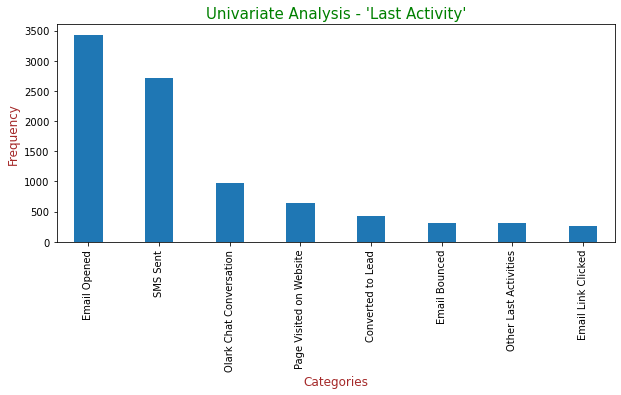

In [49]:
plt.figure(figsize=[10, 4])
df_leads_v9["Last Activity"].value_counts().plot(kind="bar", width=0.4)
plt.title("Univariate Analysis - 'Last Activity'", fontdict=global_title_design)
plt.xlabel("Categories", fontdict=global_axis_design)
plt.ylabel("Frequency", fontdict=global_axis_design)
plt.show()

#### Interpretation
- Majority of the people did open the email or sms sent to them which means the identified prospects are genuine and not robots

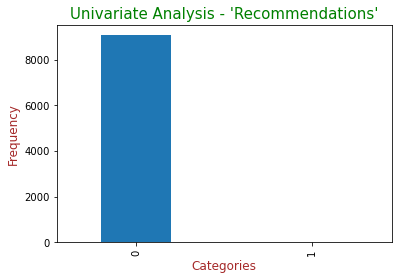

In [50]:
df_leads_v9["Recommendations"].value_counts().plot(kind="bar", width=0.4)
plt.title("Univariate Analysis - 'Recommendations'", fontdict=global_title_design)
plt.xlabel("Categories", fontdict=global_axis_design)
plt.ylabel("Frequency", fontdict=global_axis_design)
plt.show()

#### Interpretation
- Majority of the identified prospects have not come through recommendations

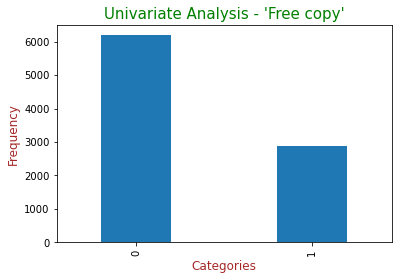

In [51]:
df_leads_v9["Free copy"].value_counts().plot(kind="bar", width=0.4)
plt.title("Univariate Analysis - 'Free copy'", fontdict=global_title_design)
plt.xlabel("Categories", fontdict=global_axis_design)
plt.ylabel("Frequency", fontdict=global_axis_design)
plt.show()

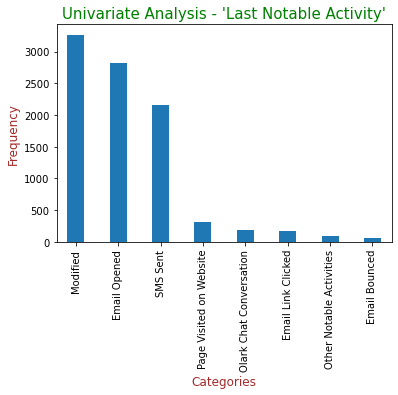

In [52]:
df_leads_v9["Last Notable Activity"].value_counts().plot(kind="bar", width=0.4)
plt.title("Univariate Analysis - 'Last Notable Activity'", fontdict=global_title_design)
plt.xlabel("Categories", fontdict=global_axis_design)
plt.ylabel("Frequency", fontdict=global_axis_design)
plt.show()

#### Interpretation
- Majority of the last notable activities performed by the student are 'Modified', 'Email Opened', 'SMS Sent'

### Numerical variable visualization

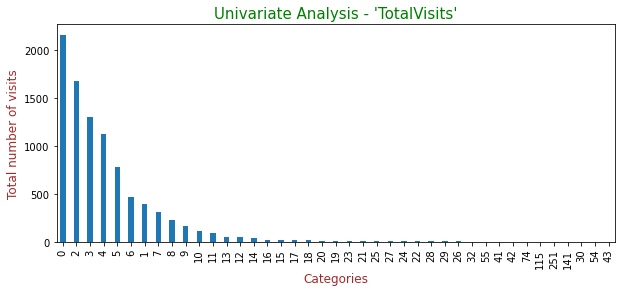

In [53]:
plt.figure(figsize=[10, 4])
df_leads_v9["TotalVisits"].value_counts().plot(kind="bar", width=0.4)
plt.title("Univariate Analysis - 'TotalVisits'", fontdict=global_title_design)
plt.xlabel("Categories", fontdict=global_axis_design)
plt.ylabel("Total number of visits", fontdict=global_axis_design)
plt.show()

#### Interpretation
- Majority of the people have not visited website yet they are being contacted. (This might be one of the reason of lower rate conversion of leads)

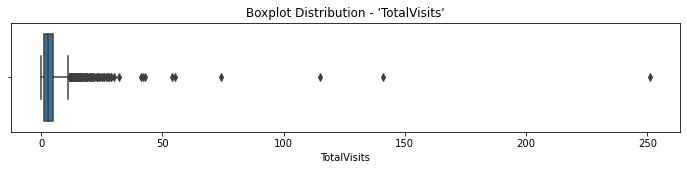

In [54]:
plt.figure(figsize=[12,2])
sns.boxplot(df_leads_v9["TotalVisits"])
plt.title("Boxplot Distribution - 'TotalVisits'")
plt.show()

In [55]:
df_leads_v9[df_leads_v9["TotalVisits"] > 100]

,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Recommendations,Free copy,Last Notable Activity
2254,637257,Landing Page Submission,Others,1,0,0,141,755,6.71,Page Visited on Website,0,1,Page Visited on Website
5496,606961,Landing Page Submission,Others,1,0,0,115,187,8.21,Page Visited on Website,0,0,Page Visited on Website
5980,602958,Landing Page Submission,Others,0,0,1,251,49,1.48,Page Visited on Website,0,1,Page Visited on Website


#### Interpretation - Outlier Analysis
- The time spent on website by the prospect is very huge (755 and 187). This is quite unusual and might be because of a bot is running on the machine.
- The third row indicates that the prospect was converted hence the number of visits to the website can be genuine.
- Since the the three rows indicate a quite unusual behaviour we decided to not include the rows for prediction

In [56]:
df_leads_v10 = df_leads_v9[df_leads_v9["TotalVisits"] <= 100]

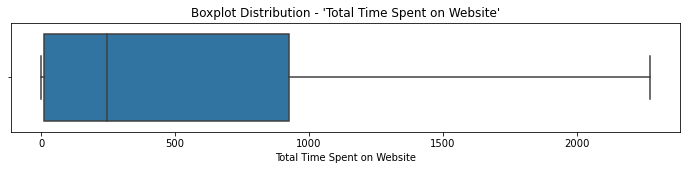

In [57]:
plt.figure(figsize=[12,2])
sns.boxplot(df_leads_v10["Total Time Spent on Website"])
plt.title("Boxplot Distribution - 'Total Time Spent on Website'")
plt.show()

#### Interpretation
- No outliers detected

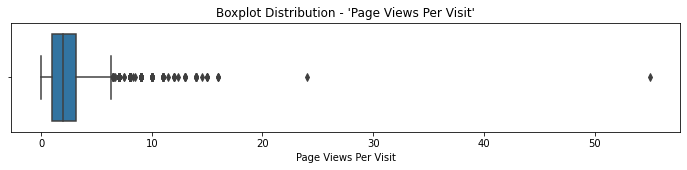

In [58]:
plt.figure(figsize=[12,2])
sns.boxplot(df_leads_v10["Page Views Per Visit"])
plt.title("Boxplot Distribution - 'Page Views Per Visit'")
plt.show()

#### Interpretation
- A student/prospect might glance through a lot of courses and hence the count of the page views per visit can go to 50. We think this is not unusual hence we keep the values as it is

### b. Bivariate Analysis

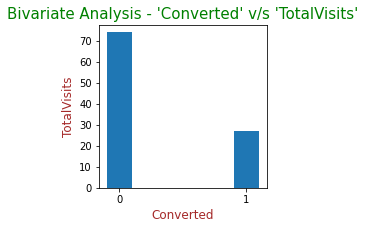

In [59]:
plt.figure(figsize=[3, 3])
plt.bar(x=df_leads_v10["Converted"].astype(str), height=df_leads_v10["TotalVisits"], width=0.2)
plt.title("Bivariate Analysis - 'Converted' v/s 'TotalVisits'", fontdict=global_title_design)
plt.xlabel("Converted", fontdict=global_axis_design)
plt.ylabel("TotalVisits", fontdict=global_axis_design)
plt.show()

#### Interpretation
- A lot of people who visited website were not converted

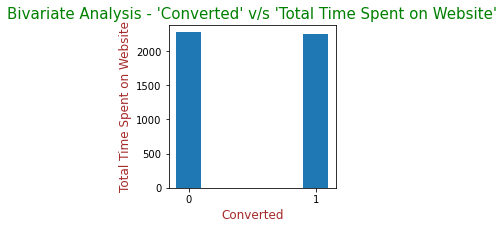

In [60]:
plt.figure(figsize=[3, 3])
plt.bar(x=df_leads_v10["Converted"].astype(str), height=df_leads_v10["Total Time Spent on Website"], width=0.2)
plt.title("Bivariate Analysis - 'Converted' v/s 'Total Time Spent on Website'", fontdict=global_title_design)
plt.xlabel("Converted", fontdict=global_axis_design)
plt.ylabel("Total Time Spent on Website", fontdict=global_axis_design)
plt.show()

#### Interpretation
- No significant difference observed between time spent and converted status of prospects

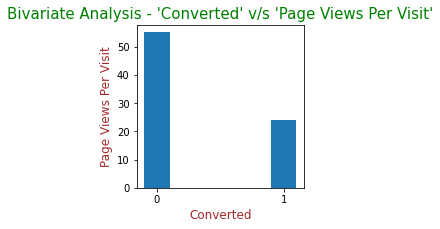

In [61]:
plt.figure(figsize=[3, 3])
plt.bar(x=df_leads_v10["Converted"].astype(str), height=df_leads_v10["Page Views Per Visit"], width=0.2)
plt.title("Bivariate Analysis - 'Converted' v/s 'Page Views Per Visit'", fontdict=global_title_design)
plt.xlabel("Converted", fontdict=global_axis_design)
plt.ylabel("Page Views Per Visit", fontdict=global_axis_design)
plt.show()

#### Interpretation
- Prospects who are not converted view pages on the website much more times than those who were converted

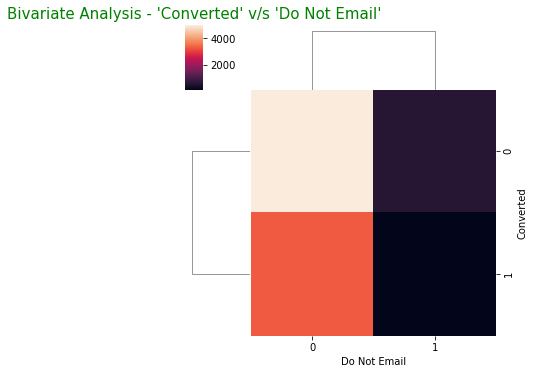

In [62]:
sns.clustermap(pd.crosstab(df_leads_v10["Converted"], df_leads_v10["Do Not Email"]), figsize=(5,5))
plt.title("Bivariate Analysis - 'Converted' v/s 'Do Not Email'", fontdict=global_title_design)
plt.show()

#### Interpretation
- Prospects who opted for email receiving service were majorly not converted. Probable cause - they were not satisfied

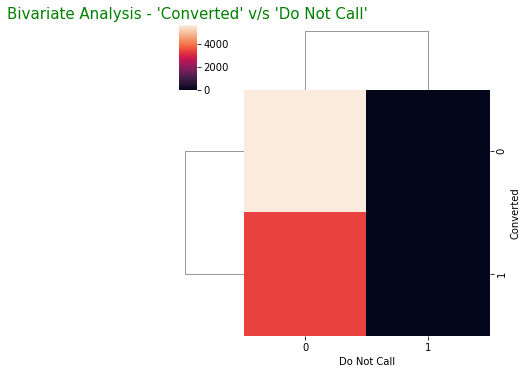

In [63]:
sns.clustermap(pd.crosstab(df_leads_v10["Converted"], df_leads_v10["Do Not Call"]), figsize=(5,5))
plt.title("Bivariate Analysis - 'Converted' v/s 'Do Not Call'", fontdict=global_title_design)
plt.show()

#### Interpretation
- Prospects who opted for phone call receiving service were majorly not converted. Probable cause - they were not satisfied

# 5. Model Building

### a. Dummy variable creation

In [64]:
lead_origin_dummy = pd.get_dummies(df_leads_v10["Lead Origin"], drop_first=True, prefix="Lead_Origin")
df_leads_v11 = pd.concat([df_leads_v10, lead_origin_dummy], axis=1)
df_leads_v11 = df_leads_v11.drop(["Lead Origin"], axis=1)

lead_source_dummy = pd.get_dummies(df_leads_v11["Lead Source"], drop_first=True, prefix="Lead_Source")
df_leads_v12 = pd.concat([df_leads_v11, lead_source_dummy], axis=1)
df_leads_v12 = df_leads_v12.drop(["Lead Source"], axis=1)

last_activity_dummy = pd.get_dummies(df_leads_v12["Last Activity"], drop_first=True, prefix="Last_Activity")
df_leads_v13 = pd.concat([df_leads_v12, last_activity_dummy], axis=1)
df_leads_v13 = df_leads_v13.drop(["Last Activity"], axis=1)

last_notable_activity_dummy = pd.get_dummies(df_leads_v13["Last Notable Activity"], drop_first=True, prefix="Last_Notable_Activity")
df_leads_v14 = pd.concat([df_leads_v13, last_notable_activity_dummy], axis=1)
df_leads_v14 = df_leads_v14.drop(["Last Notable Activity"], axis=1)

### b. Creation of X and y

In [65]:
# Before creation of X, y --> setting index as Lead Number so that probabilities can be assigned to individual leads
df_leads_v15 = df_leads_v14.set_index("Lead Number")

In [66]:
X = df_leads_v15.drop(["Converted"], axis=1) # Excluding 'Converted'
y = df_leads_v15["Converted"]

### c. Creation of train and test data

In [67]:
# Creating train-test samples with 70(training)-30(testing) ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=100)

In [68]:
# Checking the shape of individual train-test samples
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6349, 26), (2722, 26), (6349,), (2722,))

### d. Feature Scaling

In [69]:
scaler = StandardScaler()

In [70]:
X_train[["TotalVisits", "Total Time Spent on Website", "Page Views Per Visit"]] = scaler.fit_transform(X_train[["TotalVisits", "Total Time Spent on Website", "Page Views Per Visit"]])
X_train.head(3)

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Recommendations,Free copy,Lead_Origin_Landing Page Submission,Lead_Origin_Lead Add Form,Lead_Origin_Lead Import,...,Last_Activity_Other Last Activities,Last_Activity_Page Visited on Website,Last_Activity_SMS Sent,Last_Notable_Activity_Email Link Clicked,Last_Notable_Activity_Email Opened,Last_Notable_Activity_Modified,Last_Notable_Activity_Olark Chat Conversation,Last_Notable_Activity_Other Notable Activities,Last_Notable_Activity_Page Visited on Website,Last_Notable_Activity_SMS Sent
Lead Number,,,,,,,,,,,,,,,,,,,,,
594933,0,0,-0.11,-0.71,0.31,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
614251,0,0,-0.94,-0.88,-1.14,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
588625,0,0,0.45,2.03,0.07,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0


### e. Checking correlations

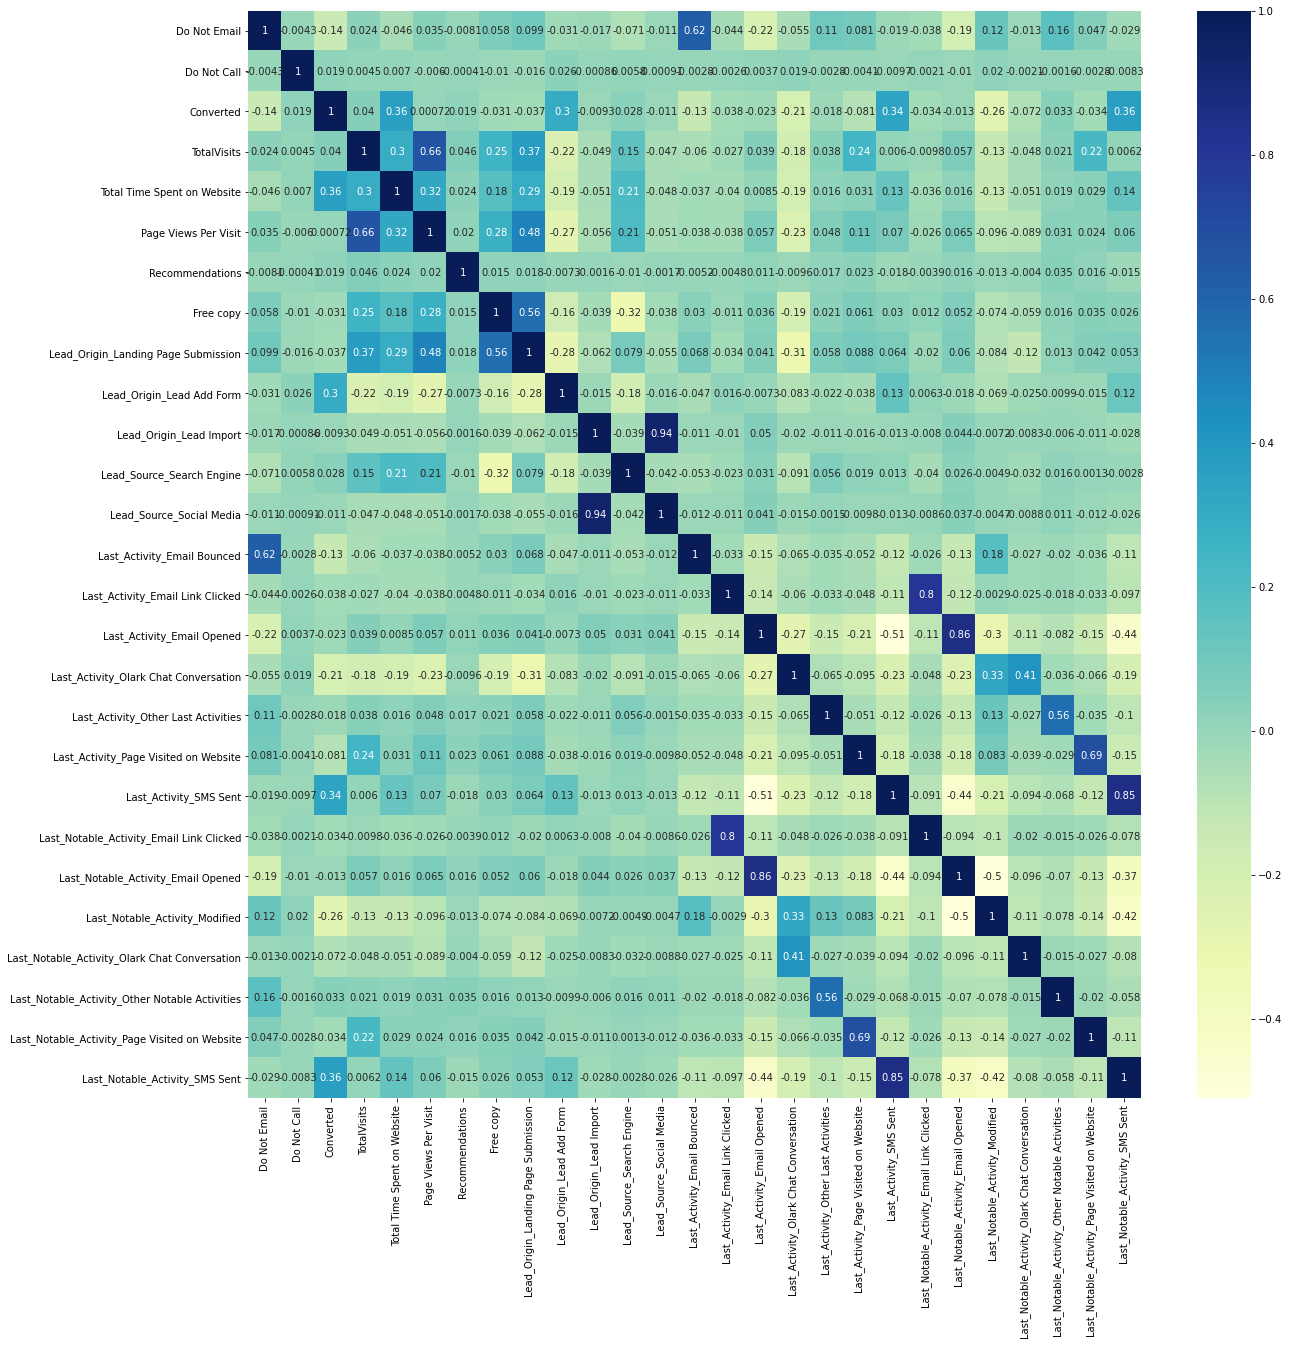

In [71]:
plt.figure(figsize=[20, 20])
sns.heatmap(df_leads_v15.corr(), annot=True, cmap="YlGnBu")
plt.show()

#### Interpretation
- We can drop the columns that are highly correlated because the variance of one column is explained by another column well.
- Lead_Source_Social_Media and Lead_Origin_Lead_Import are highly correlated. Hence, we decided to drop Lead Source activities as we are interested in knowing the identifier with which the customer/prospect was identified as a lead at first place
- Last_Notable_Activity_Email Link Clicked and Last_Activity_Email Link Clicked
- Last_Notable_Activity_Email Opened and Last_Activity_Email Opened
- Last_Notable_SMS Sent and Last_Activity_SMS Sent
  <br> are highly correlated. We decided to Last Notable Activities as we are interested in capturing the interesting and latest activity information

In [72]:
X_train_v2 = X_train.drop([
    "Lead_Source_Social Media", 
    "Last_Activity_Email Link Clicked", 
    "Last_Activity_Email Opened", 
    "Last_Activity_SMS Sent"], axis=1)
X_test_v2 = X_test.drop([
    "Lead_Source_Social Media", 
    "Last_Activity_Email Link Clicked", 
    "Last_Activity_Email Opened", 
    "Last_Activity_SMS Sent"], axis=1)

### f. Feature selection using RFE

In [73]:
def get_variance_inflation_factor(data):
    vif = pd.DataFrame()
    vif["Features"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    vif["VIF"] = round(vif["VIF"], 2)
    print(vif.sort_values(by="VIF", ascending=False))

In [74]:
lg_rfe = LogisticRegression()
rfe_20 = RFE(lg_rfe, 20)
rfe_20 = rfe_20.fit(X_train_v2, y_train)

In [75]:
top_20_columns = X_train_v2.columns[rfe_20.support_]
X_train_v3 = X_train_v2[top_20_columns]
X_test_v3 = X_test_v2[top_20_columns]

#### Building the model using statsmodels
#### Interpretation
- Criteria for dropping features that are multicollinear in nature
    - High VIF, and High p-value: drop immediately and then create a new model
    - High p-value and Low VIF: remove these first, and then create a new model
    - Low p-value and High VIF: remove these and then create a new model
    - Low p-value and Low VIF: don't drop such features
- Threshold criteria
    - VIF < 5.5 is acceptable
    - p-value < 0.05 is acceptable

### g. Building model

In [76]:
log_reg_v1 = sm.GLM(y_train, (sm.add_constant(X_train_v3)), family=sm.families.Binomial())
print(log_reg_v1.fit().summary())
get_variance_inflation_factor(X_train_v3)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6349
Model:                            GLM   Df Residuals:                     6328
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2853.3
Date:                Tue, 20 Jun 2023   Deviance:                       5706.6
Time:                        13:30:58   Pearson chi2:                 6.54e+03
No. Iterations:                    19                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

#### Interpretation
- 'Do Not Call' have a very high p-value hence we decided to drop it

In [77]:
X_train_v4 = X_train_v3.drop(["Do Not Call"], axis=1)

In [78]:
# Rebuilding the model
log_reg_v2 = sm.GLM(y_train, (sm.add_constant(X_train_v4)), family=sm.families.Binomial())
print(log_reg_v2.fit().summary())
get_variance_inflation_factor(X_train_v4)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6349
Model:                            GLM   Df Residuals:                     6329
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2854.0
Date:                Tue, 20 Jun 2023   Deviance:                       5708.1
Time:                        13:30:59   Pearson chi2:                 6.54e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

#### Interpretation
- 'Last_Notable_Activity_Other Notable Activities' has a very high p-value, hence we drop the column

In [79]:
X_train_v5 = X_train_v4.drop("Last_Notable_Activity_Other Notable Activities", axis=1)

In [80]:
# Rebuilding the model
log_reg_v3 = sm.GLM(y_train, (sm.add_constant(X_train_v5)), family=sm.families.Binomial())
print(log_reg_v3.fit().summary())
get_variance_inflation_factor(X_train_v5)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6349
Model:                            GLM   Df Residuals:                     6330
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2854.1
Date:                Tue, 20 Jun 2023   Deviance:                       5708.2
Time:                        13:30:59   Pearson chi2:                 6.54e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

#### Interpretation
'Last_Notable_Activity_SMS Sent' has a high p-value hence we decided to drop the column

In [81]:
X_train_v6 = X_train_v5.drop("Last_Notable_Activity_SMS Sent", axis=1)

In [82]:
# Rebuilding the model
log_reg_v4 = sm.GLM(y_train, (sm.add_constant(X_train_v6)), family=sm.families.Binomial())
print(log_reg_v4.fit().summary())
get_variance_inflation_factor(X_train_v6)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6349
Model:                            GLM   Df Residuals:                     6331
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2854.1
Date:                Tue, 20 Jun 2023   Deviance:                       5708.3
Time:                        13:31:00   Pearson chi2:                 6.54e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

#### Interpretation
'Free copy' has a high p-value hence we decided to drop the column

In [83]:
X_train_v7 = X_train_v6.drop("Free copy", axis=1)

In [84]:
# Rebuilding the model
log_reg_v5 = sm.GLM(y_train, (sm.add_constant(X_train_v7)), family=sm.families.Binomial())
print(log_reg_v5.fit().summary())
get_variance_inflation_factor(X_train_v7)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6349
Model:                            GLM   Df Residuals:                     6332
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2854.8
Date:                Tue, 20 Jun 2023   Deviance:                       5709.6
Time:                        13:31:00   Pearson chi2:                 6.53e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

#### Interpretation
'Recommendations' has a high p-value hence we decided to drop the column

In [85]:
X_train_v8 = X_train_v7.drop("Recommendations", axis=1)

In [86]:
# Rebuilding the model
log_reg_v6= sm.GLM(y_train, (sm.add_constant(X_train_v8)), family=sm.families.Binomial())
print(log_reg_v6.fit().summary())
get_variance_inflation_factor(X_train_v8)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6349
Model:                            GLM   Df Residuals:                     6333
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2856.3
Date:                Tue, 20 Jun 2023   Deviance:                       5712.6
Time:                        13:31:01   Pearson chi2:                 6.53e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

#### Interpretation
- The p-value and VIF of all the features is within the threshold range. Hence we finalize this model

# 6. Model Evaluation

### a. Prediction on training dataset

In [87]:
X_train_final = sm.add_constant(X_train_v8)
log_reg_final = sm.GLM(y_train, X_train_final, family=sm.families.Binomial())
final_fit = log_reg_final.fit()

#### Testing accuracy on training dataset

In [88]:
y_train_pred = final_fit.predict(X_train_final)

In [89]:
# Creation of dataframe for accuracy check
y_train_pred = y_train_pred.values.reshape(-1)
df_train = pd.DataFrame({
    "Lead Number": y_train.index,
    "Converted": y_train.values,
    "Converted Probability": y_train_pred
})

In [90]:
# Converting "Converted Probability" to 1 if probabilty > 0.5 else 0
df_train["Prediction"] = df_train["Converted Probability"].map(lambda x: 1 if x > 0.5 else 0)

In [91]:
# Checking the train dataset
df_train.head(5) # Looks okay

,Lead Number,Converted,Converted Probability,Prediction
0,594933,0,0.06,0
1,614251,0,0.04,0
2,588625,1,0.66,1
3,646388,1,0.81,1
4,593063,1,0.85,1


In [92]:
# Checking the accuracy of the model
c_matrix = confusion_matrix(df_train["Converted"], df_train["Prediction"])
print(c_matrix)

[[3394  533]
 [ 758 1664]]


In [93]:
print(round(accuracy_score(df_train["Converted"], df_train["Prediction"]), 2))

0.8


In [94]:
def get_evaluation_details(c_matrix):
    """
        input: confusion matrix
        output: list containing sensitivity, specificty, false_positive_rate, precision, negative_predicted_value
    """
    true_positive = c_matrix[1, 1]
    true_negative = c_matrix[0, 0]
    false_positive = c_matrix[0, 1]
    false_negative = c_matrix[1, 0]

    print("For the below confusion matrix following are the evaluation metrics: \n", c_matrix)
    print("Sensitivity = ", (true_positive / float(true_positive + false_negative)))
    print("Specificity = ", (true_negative / float(true_negative + false_positive)))
    print("False Positive Rate = ", (1 - (true_negative / float(true_negative + false_positive))))
    print("Precision = ", (true_positive / float(true_positive + false_positive)))
    print("Negative Predicted Value = ", (true_negative / float(true_negative + false_negative)))

In [95]:
# Calculating sensitivity
get_evaluation_details(c_matrix)

For the below confusion matrix following are the evaluation metrics: 
 [[3394  533]
 [ 758 1664]]
Sensitivity =  0.6870355078447564
Specificity =  0.8642729819200408
False Positive Rate =  0.13572701807995924
Precision =  0.757396449704142
Negative Predicted Value =  0.8174373795761078


#### Drawing the ROC curve

In [96]:
def draw_roc(actual, probs):
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs, drop_intermediate = False)
    auc_score = metrics.roc_auc_score(actual, probs)
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]', fontdict=global_axis_design)
    plt.ylabel('True Positive Rate', fontdict=global_axis_design)
    plt.title('Receiver operating characteristic curve', fontdict=global_title_design)
    plt.legend(loc="lower right")
    plt.show()

    return None

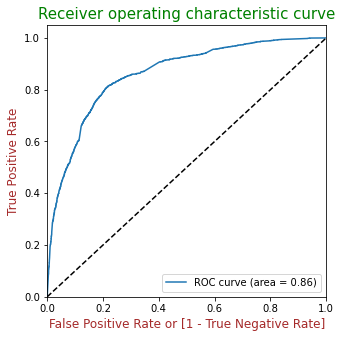

In [97]:
draw_roc(df_train["Converted"], df_train["Converted Probability"])

#### Interpretation
- The area covered under the curve should be closer to 1 and in our case it is 0.86 which is a good sign

#### Finding the optimal cut off threshold
- Since we have randomly chosen 0.5 as our cut-off we need to find the optimal threshold to increase the accuracy of the model

In [98]:
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    df_train[i]= df_train["Converted Probability"].map(lambda x: 1 if x > i else 0)

In [99]:
df_train.head()

,Lead Number,Converted,Converted Probability,Prediction,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,594933,0,0.06,0,1,0,0,0,0,0,0,0,0,0
1,614251,0,0.04,0,1,0,0,0,0,0,0,0,0,0
2,588625,1,0.66,1,1,1,1,1,1,1,1,0,0,0
3,646388,1,0.81,1,1,1,1,1,1,1,1,1,1,0
4,593063,1,0.85,1,1,1,1,1,1,1,1,1,1,0


In [100]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specificity'])

num = [i/10 for i in range(0, 10)]
for i in num:
    cm1 = metrics.confusion_matrix(df_train["Converted"], df_train[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[i, accuracy, sensi, speci]
print(cutoff_df)

      prob  accuracy  sensitivity  specificity
0.00  0.00      0.38         1.00         0.00
0.10  0.10      0.54         0.98         0.27
0.20  0.20      0.71         0.91         0.58
0.30  0.30      0.78         0.83         0.76
0.40  0.40      0.80         0.77         0.81
0.50  0.50      0.80         0.69         0.86
0.60  0.60      0.77         0.54         0.91
0.70  0.70      0.76         0.45         0.95
0.80  0.80      0.73         0.35         0.97
0.90  0.90      0.69         0.20         0.99


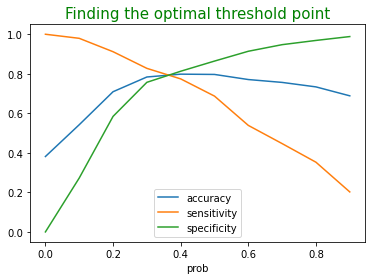

In [101]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensitivity','specificity'])
plt.title("Finding the optimal threshold point", fontdict=global_title_design)
plt.show()

#### Interpretation
- From the intersection point the optimum point is nearly 0.35. Hence, we take the optimal cut-off point as 0.35

In [102]:
df_train["Final Prediction"] = df_train["Converted Probability"].map(lambda x: 1 if x > 0.35 else 0)

In [103]:
df_train.head()

,Lead Number,Converted,Converted Probability,Prediction,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,Final Prediction
0,594933,0,0.06,0,1,0,0,0,0,0,0,0,0,0,0
1,614251,0,0.04,0,1,0,0,0,0,0,0,0,0,0,0
2,588625,1,0.66,1,1,1,1,1,1,1,1,0,0,0,1
3,646388,1,0.81,1,1,1,1,1,1,1,1,1,1,0,1
4,593063,1,0.85,1,1,1,1,1,1,1,1,1,1,0,1


In [104]:
c_matrix_2 = confusion_matrix(df_train["Converted"], df_train["Final Prediction"])
get_evaluation_details(c_matrix_2)

For the below confusion matrix following are the evaluation metrics: 
 [[3091  836]
 [ 465 1957]]
Sensitivity =  0.8080099091659785
Specificity =  0.7871148459383753
False Positive Rate =  0.21288515406162467
Precision =  0.7006802721088435
Negative Predicted Value =  0.8692350956130483


#### Interpretation
- Out of the total customers that actually converted i.e, 2422 our model correctly predicted 1999 with an accuracy of 82.53%. This is a good score

#### Creation of lead_score
- Lead Score = Converted Probability * 100

In [105]:
df_train["Lead Score"] = df_train["Converted Probability"] * 100
df_train.head()

,Lead Number,Converted,Converted Probability,Prediction,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,Final Prediction,Lead Score
0,594933,0,0.06,0,1,0,0,0,0,0,0,0,0,0,0,6.18
1,614251,0,0.04,0,1,0,0,0,0,0,0,0,0,0,0,4.34
2,588625,1,0.66,1,1,1,1,1,1,1,1,0,0,0,1,66.15
3,646388,1,0.81,1,1,1,1,1,1,1,1,1,1,0,1,81.03
4,593063,1,0.85,1,1,1,1,1,1,1,1,1,1,0,1,84.62


In [106]:
round(metrics.accuracy_score(df_train["Converted"], df_train["Final Prediction"]),2)

0.8

#### Plotting the precision-recall curve

In [107]:
p, r, thresholds = precision_recall_curve(df_train["Converted"], df_train["Converted Probability"])

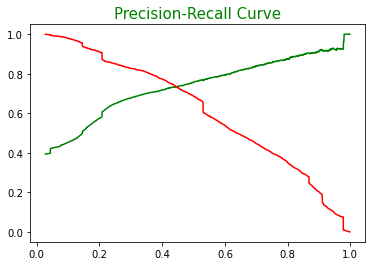

In [108]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.title("Precision-Recall Curve", fontdict=global_title_design)
plt.show()

#### Model prediction on test set

In [109]:
# Scaling the test dataset
X_test_v3[["TotalVisits", "Total Time Spent on Website", "Page Views Per Visit"]] = scaler.transform(X_test_v3[["TotalVisits", "Total Time Spent on Website", "Page Views Per Visit"]])
X_test_v3.head(3)

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Recommendations,Free copy,Lead_Origin_Landing Page Submission,Lead_Origin_Lead Add Form,Lead_Origin_Lead Import,Last_Activity_Email Bounced,Last_Activity_Olark Chat Conversation,Last_Activity_Page Visited on Website,Last_Notable_Activity_Email Link Clicked,Last_Notable_Activity_Email Opened,Last_Notable_Activity_Modified,Last_Notable_Activity_Olark Chat Conversation,Last_Notable_Activity_Other Notable Activities,Last_Notable_Activity_Page Visited on Website,Last_Notable_Activity_SMS Sent
Lead Number,,,,,,,,,,,,,,,,,,,,
614694,0,0,1.56,-0.72,1.03,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
607411,0,0,0.17,1.76,-0.17,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
607556,0,0,1.00,-0.77,2.24,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [110]:
# Dropping the columns from the testing dataset that we removed earlier
X_test_v4 = X_test_v3.drop([
    "Do Not Call",
    "Last_Notable_Activity_Other Notable Activities",
    "Last_Notable_Activity_SMS Sent",
    "Free copy",
    "Recommendations"
], axis=1)

In [111]:
X_test_v5 = sm.add_constant(X_test_v4)

In [112]:
y_test_pred = final_fit.predict(X_test_v5)

In [113]:
df_test = pd.DataFrame({
    "Lead Number": y_test.index,
    "Converted": y_test.values,
    "Converted Probability": y_test_pred
})

In [114]:
df_test.head()

,Lead Number,Converted,Converted Probability
Lead Number,,,
614694,614694,1,0.43
607411,607411,0,0.49
607556,607556,0,0.11
645763,645763,1,0.10
620626,620626,0,0.01


In [115]:
df_test["Final Prediction"] = df_test["Converted Probability"].map(lambda x: 1 if x > 0.35 else 0)

In [116]:
df_test["Lead Score"] = df_test["Converted Probability"] * 100

In [117]:
c_matrix = confusion_matrix(df_test["Converted"], df_test["Final Prediction"])
get_evaluation_details(c_matrix)

For the below confusion matrix following are the evaluation metrics: 
 [[1332  378]
 [ 190  822]]
Sensitivity =  0.8122529644268774
Specificity =  0.7789473684210526
False Positive Rate =  0.2210526315789474
Precision =  0.685
Negative Predicted Value =  0.8751642575558476


In [118]:
round(accuracy_score(df_test["Converted"], df_test["Final Prediction"]), 1)

0.8

In [119]:
round(recall_score(df_test["Converted"], df_test["Final Prediction"]), 2)

0.81

<html>
    <h3 style="color:green;text-align:center">Model Evaluation Results</h3>
    <table>
        <tr>
            <th>Measure</th>
            <th>Training Data</th>
            <th>Testing Data</th>
        </tr>
        <tr>
            <td>Sensitivity</td>
            <td>80.80%</td>
            <td>81.22%</td>
        </tr>
        <tr>
            <td>Specificity</td>
            <td>78.71%</td>
            <td>77.89%</td>
        </tr>
        <tr>
            <td>Overall Accuracy</td>
            <td>80%</td>
            <td>80%</td>
        </tr>
        <tr>
            <td>False Positive Rate</td>
            <td>21.28%</td>
            <td>22.10%</td>
        </tr>
    </table>
</html>

#### Interpretation
- The Overall accuracy of the model remained same through testing and training dataset and a much drastic difference in the accuracy of the both was not observed. This ensures that the model is stable and reliable.
- The false positive rate is low and this ensures that the firm can rely on the model
- The sensitivity of the model is approximately 81% ensuring that out of the given samples the model accurately predicted 81% of the prospects which is a positive sign
- For future purpose the model can be fine tuned by adding/removing features thereby increasing the accuracy to a higher level, but since the training and testing dataset are giving the same level of accuracy we finalized the model